In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torchtext
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import os
import string
import math
import nltk
import re
from collections import Counter

from helper import *

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
DATA_DIR = {
    "train": {2017: "data/train2017",
              2014: "data/train2014"},
    
    "val": "data/val2017",
    "test": "data/test2017",
    "annotation": {
        2017: { "train": "data/annotations/captions_train2017.json",
                "val": "data/annotations/captions_val2017.json"},
        2014: { "train": "data/annotations/captions_train2014.json"}
    }
}

In [6]:
traindict = process_data(DATA_DIR["annotation"][2014]["train"])

TRAINING_SAMPLES = len(traindict)
print(f"Number of training samples: {TRAINING_SAMPLES} images")

Number of training samples: 82783 images


In [7]:
class DataAnalyzer:
    def __init__(self, datadict, tokenizer):
        self.datadict = list(traindict.values())
        self.captions_list = self.inititate_caption()
        self.cnt_lengths = [Counter(), Counter(), Counter(), Counter(), Counter()]
        self.cnt_n_grams = [Counter(), Counter(), Counter(), Counter(), Counter()]
        self.n_grams = 0
        self.tokenizer = tokenizer
    def inititate_caption(self):
        """
        Inititate captions list by index
        """
        result_list = []
        for i in tqdm(range(len(self.datadict))):
            captions_list = self.datadict[i]["captions"]
            for idx, caps in enumerate(captions_list):
                if idx>=len(result_list):
                    result_list.append([caps])
                else:
                    result_list[idx].append(caps)
        return result_list      
            
    def generate_n_grams(self,sentence,n):
        """
        Input a sentence, and leve of n-grams
        Output n-grams list
        """
        x = self.tokenizer(sentence)
        if n == 1:
            return x
        result = []
        n_grams = set(zip(*[x[i:] for i in range(n)]))
        for n_gram in n_grams:
            result.append(' '.join(n_gram))
        return result

    def analyze_freq(self,n_grams=1, idx = None):
        """
        Analyze the captions and return a Counter object
        """
        if self.n_grams==0:
            self.n_grams=n_grams
            
        assert self.n_grams==n_grams, "n-grams don't match"
        assert idx==None or (idx>=0 and idx<=4) , "Index must be between 0-4 or None"
        
        if idx is None:
            all_idx = Counter()
            for i in range(5):
                all_idx += self.analyze_freq(n_grams, idx=i)
            return all_idx
        else:
            captions_list = self.captions_list[idx]
        
        if len(self.cnt_n_grams[idx]) == 0:
            print("Start analyzing...")
            for caption in tqdm(captions_list):
                n_gram_tokens = self.generate_n_grams(caption,n_grams)
                self.cnt_n_grams[idx].update(n_gram_tokens)
            print("Analyzing Completed!")
        return self.cnt_n_grams[idx]
    
    def visualize_top_k(self, mode,idx = None, k = 10):
        
        assert mode in ["freqs", "len"], "mode must be 'freqs' or 'len'"
        
        if mode=="freqs":
            count_dict = self.analyze_freq(n_grams=self.n_grams, idx = idx)
        if mode == "len":
            count_dict = self.analyze_length(idx = idx)
            
        def top_k_words(count_dict, k):
            top_k = count_dict.most_common(k)
            return top_k

        top_k = top_k_words(count_dict,k)
        words = [i[0] for i in top_k]
        freqs = [i[1] for i in top_k]

        fig, ax = plt.subplots(figsize=(20,15))
        y_pos = np.arange(len(words))
        rgb = np.random.rand(3,)
        ax.barh(y_pos, freqs, align='center',color=[rgb])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words,fontsize=20)
        ax.invert_yaxis()
        if mode == "freqs":
            ax.set_xlabel('Frequency',fontsize=20)
            ax.set_title(f'Top {k} common words',fontsize=20)
        else:
            ax.set_xlabel('Length',fontsize=20)
            ax.set_title(f'Top {k} length',fontsize=20)
        plt.show()
    
    def analyze_length(self,idx=None):
        assert idx==None or (idx>=0 and idx<=4) , "Index must be between 0-4 or None"
        if idx is None:
            all_idx = Counter()
            for i in range(5):
                all_idx += self.analyze_length(idx=i)
            return all_idx
        else:
            captions_list = self.captions_list[idx]
            
        if len(self.cnt_lengths[idx]) == 0:
            print("Start analyzing...")
            for caption in tqdm(captions_list):
                tokens = self.tokenizer(caption)
                self.cnt_lengths[idx].update([len(tokens)])
            print("Analyzing Completed!")
        return self.cnt_lengths[idx]
    
    def __len__(self):
        return len(self.datadict)

In [8]:
analyze = DataAnalyzer(traindict, tokenizer=mytokenizer)

In [12]:
analyze.analyze_length()
print(len(analyze.analyze_freq()))

25113


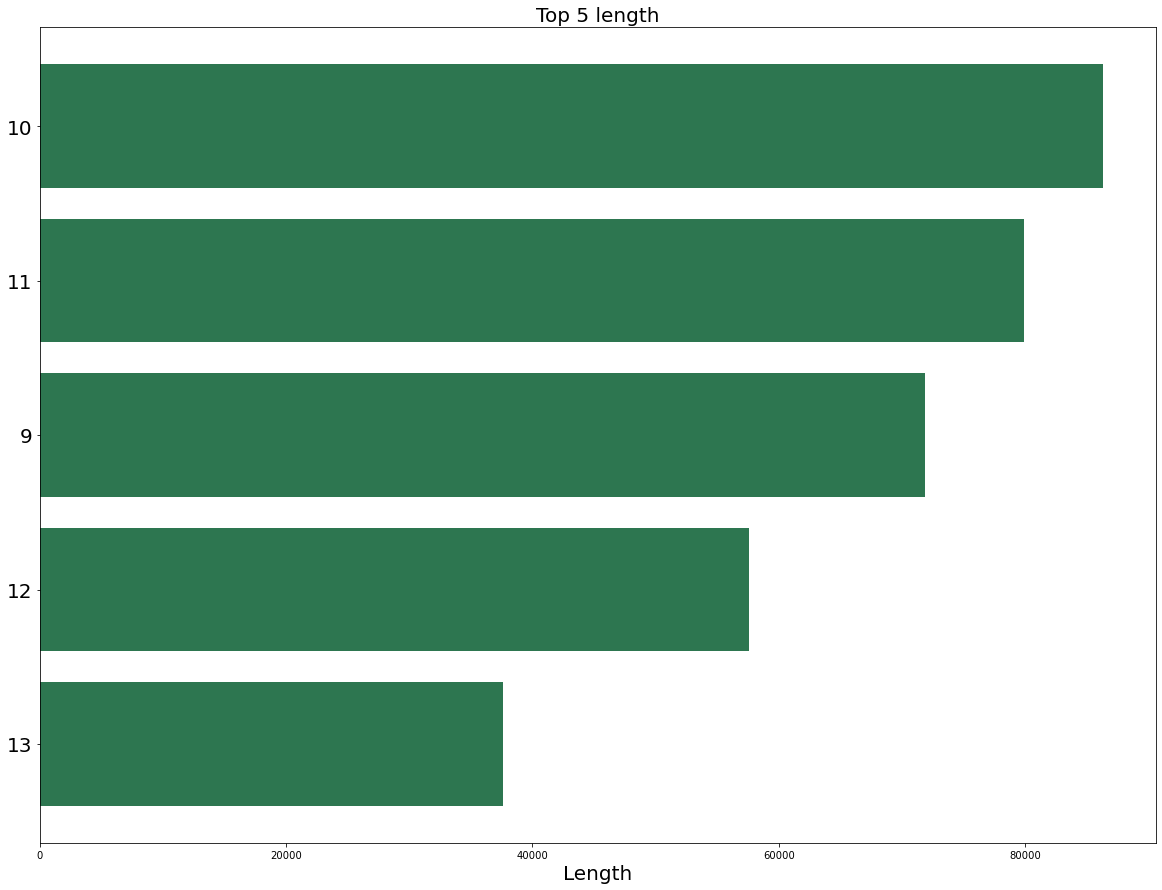

In [10]:
analyze.visualize_top_k(mode="len",k=5)

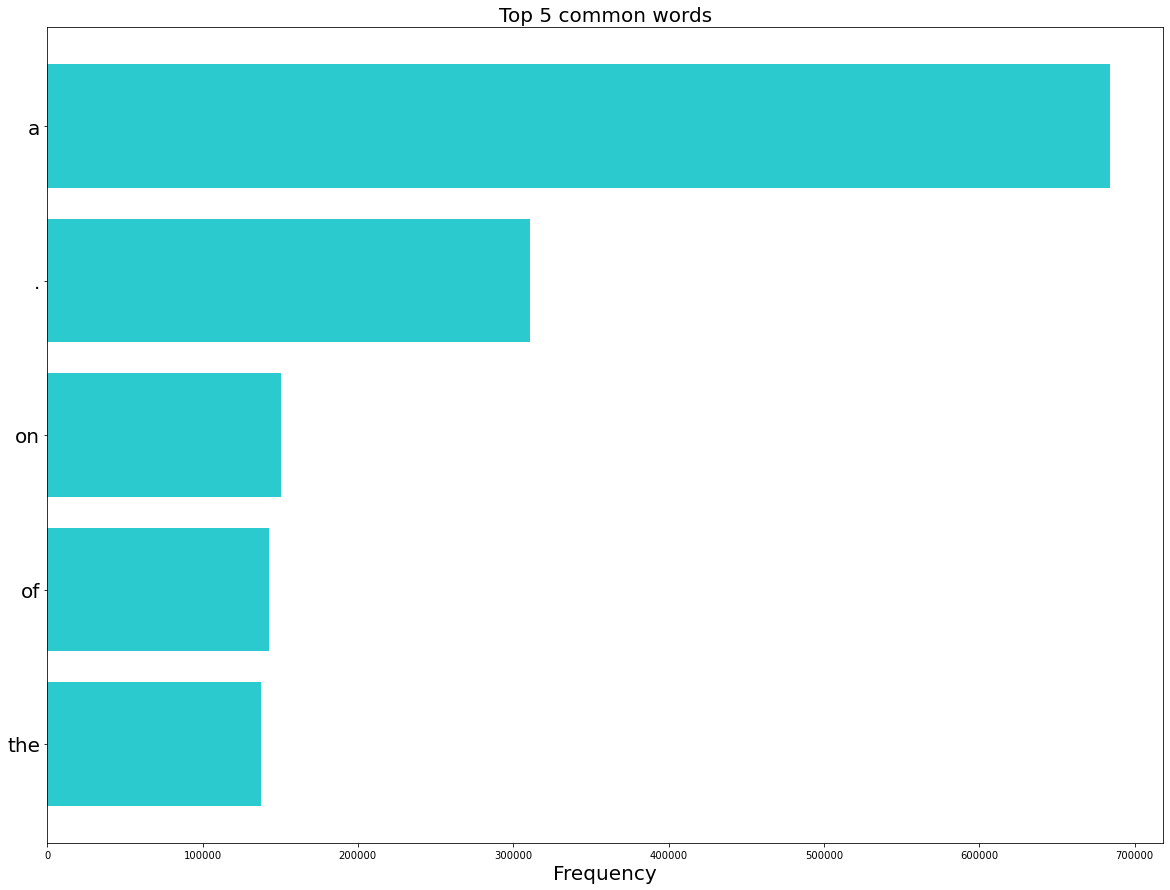

In [11]:
analyze.visualize_top_k(mode="freqs",k=5)